# Predict Next Purchase

In this tutorial, build a machine learning application that predicts whether customers will purchase a product within the next shopping period. This application is structured into three important steps:

- Prediction Engineering
- Feature Engineering
- Machine Learning

In the first step, you generate new labels from the data by using [Compose](https://compose.alteryx.com/). In the second step, you generate features for the labels by using [Featuretools](https://docs.featuretools.com/). In the third step, you search for the best machine learning pipeline by using [EvalML](https://evalml.alteryx.com/). After working through these steps, you should understand how to build machine learning applications for real-world problems like predicting consumer spending.

In [1]:
from demo.next_purchase import load_sample
from matplotlib.pyplot import subplots
import composeml as cp
import featuretools as ft
import evalml

Use this historical data of online grocery orders provided by [Instacart](https://www.kaggle.com/c/instacart-market-basket-analysis/data).

In [2]:
df = load_sample()
df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,user_id,order_time
id,,,,,,,,,,
24,623,33120,1,1,Organic Egg Whites,86,16,dairy eggs,37804,2015-01-04 12:00:00
25,623,40706,3,1,Organic Grape Tomatoes,123,4,produce,37804,2015-01-04 12:00:00
26,623,38777,5,1,Organic Green Seedless Grapes,123,4,produce,37804,2015-01-04 12:00:00
27,623,34126,9,1,Organic Italian Parsley Bunch,16,4,produce,37804,2015-01-04 12:00:00
28,623,19678,4,1,Organic Russet Potato,83,4,produce,37804,2015-01-04 12:00:00


## Prediction Engineering

> Will customers purchase a product within the next shopping period?

In this prediction problem, there are two parameters:

- The product that a customer can purchase.
- The length of the shopping period.

You can change these parameters to create different prediction problems. For example, will a customer purchase a banana within the next 3 days or an avocado within the next three weeks? These variations can be done by simply tweaking the parameters. This helps you explore different scenarios that are crucial for making better decisions.

### Defining the Labeling Function

Start by defining a labeling function that checks if a customer bought a given product. Make the product a parameter of the function. Our labeling function is used by a label maker to extract the training examples.

In [3]:
def bought_product(ds, product_name):
    return ds.product_name.str.contains(product_name).any()

### Representing the Prediction Problem

Represent the prediction problem by creating a label maker with the following parameters:

- `target_entity` as the columns for the customer ID, since you want to process orders for each customer.
- `labeling_function` as the function you defined previously.
- `time_index` as the column for the order time. The shoppings periods are based on this time index.
- `window_size` as the length of a shopping period. You can easily change this parameter to create variations of the prediction problem.

In [4]:
lm = cp.LabelMaker(
    target_entity='user_id',
    time_index='order_time',
    labeling_function=bought_product,
    window_size='3d',
)

### Finding the Training Examples

Run a search to get the training examples by using the following parameters:

- The grocery orders sorted by the order time, since the search expects the orders to be sorted chronologically. Otherwise, an error is raised.
- `num_examples_per_instance` to find the number of training examples per customer. In this case, the search returns all existing examples.
- `product_name` as the product to check for purchases. This parameter gets passed directly to the our labeling function.
- `minimum_data` as the amount of data that is used to make features for the first training example.

In [5]:
lt = lm.search(
    df.sort_values('order_time'),
    num_examples_per_instance=-1,
    product_name='Banana',
    minimum_data='3d',
    verbose=False,
)

lt.head()

,user_id,time,bought_product
0,6851,2015-02-05 22:00:00,True
1,8167,2015-01-14 11:00:00,False
2,8167,2015-01-20 11:00:00,False
3,19114,2015-01-13 13:00:00,True
4,31606,2015-01-06 09:00:00,False


The output from the search is a label times table with three columns:

- The customer ID associated to the orders. There can be many training examples generated from each customer.
- The start time of the shopping period. This is also the cutoff time for building features. Only data that existed beforehand is valid to use for predictions.
- Whether the product was purchased during the shopping period window. This is calculated by our labeling function.

As a helpful reference, you can print out the search settings that were used to generate these labels. The description also shows us the label distribution which we can check for imbalanced labels.

In [6]:
lt.describe()

Label Distribution
------------------
False      7
True       6
Total:    13


Settings
--------
gap                                    None
minimum_data                             3d
num_examples_per_instance                -1
target_column                bought_product
target_entity                       user_id
target_type                        discrete
window_size                              3d


Transforms
----------
No transforms applied



You can get a better look at the labels by plotting the distribution and cumulative count across time.

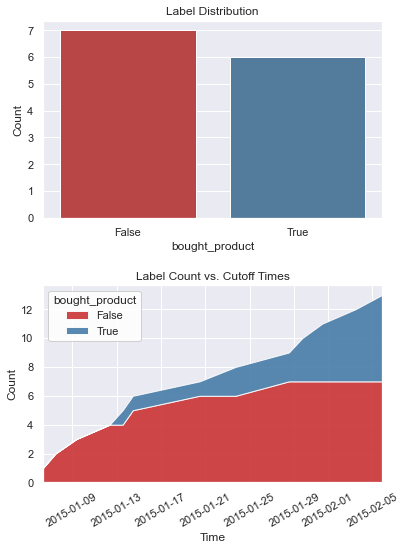

In [7]:
%matplotlib inline
fig, ax = subplots(nrows=2, ncols=1, figsize=(6, 8))
lt.plot.distribution(ax=ax[0])
lt.plot.count_by_time(ax=ax[1])
fig.tight_layout(pad=2)

## Feature Engineering

In the previous step, you generated the labels. The next step is to generate features.

### Representing the Data

Start by representing the data with an entity set. That way, you can generate features based on the relational structure of the dataset. You currently have a single table of orders where one customer can have many orders. This one-to-many relationship can be represented by normalizing a customer entity. The same can be done for other one-to-many relationships like aisle-to-products. Because you want to make predictions based on the customer, you should use this customer entity as the target entity for generating features.

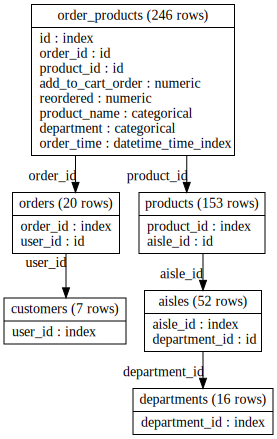

In [8]:
es = ft.EntitySet('instacart')

es.entity_from_dataframe(
    dataframe=df.reset_index(),
    entity_id='order_products',
    time_index='order_time',
    index='id',
)

es.normalize_entity(
    base_entity_id='order_products',
    new_entity_id='orders',
    index='order_id',
    additional_variables=['user_id'],
    make_time_index=False,
)

es.normalize_entity(
    base_entity_id='orders',
    new_entity_id='customers',
    index='user_id',
    make_time_index=False,
)

es.normalize_entity(
    base_entity_id='order_products',
    new_entity_id='products',
    index='product_id',
    additional_variables=['aisle_id', 'department_id'],
    make_time_index=False,
)

es.normalize_entity(
    base_entity_id='products',
    new_entity_id='aisles',
    index='aisle_id',
    additional_variables=['department_id'],
    make_time_index=False,
)

es.normalize_entity(
    base_entity_id='aisles',
    new_entity_id='departments',
    index='department_id',
    make_time_index=False,
)

es["order_products"]["department"].interesting_values = ['produce']
es["order_products"]["product_name"].interesting_values = ['Banana']
es.plot()

### Calculating the Features

Now you can generate features by using a method called Deep Feature Synthesis (DFS). That method automatically builds features by stacking and applying mathematical operations called primitives across relationships in an entity set. The more structured an entity set is, the better DFS can leverage the relationships to generate better features. Let’s run DFS using the following parameters:

- `entity_set` as the entity set we structured previously.
- `target_entity` as the customer entity.
- `cutoff_time` as the label times that we generated previously. The label values are appended to the feature matrix.

In [12]:
fm, fd = ft.dfs(
    entityset=es,
    target_entity='customers',
    cutoff_time=lt,
    cutoff_time_in_index=True,
    include_cutoff_time=False,
    verbose=False,
)

fm.head()

COUNT(orders)  COUNT(order_products)  \
user_id time                                                        
6851    2015-02-05 22:00:00              2                     14   
8167    2015-01-14 11:00:00              3                      9   
        2015-01-20 11:00:00              3                     17   
19114   2015-01-13 13:00:00              2                     25   
31606   2015-01-06 09:00:00              4                      9   

                             MAX(order_products.add_to_cart_order)  \
user_id time                                                         
6851    2015-02-05 22:00:00                                     14   
8167    2015-01-14 11:00:00                                      9   
        2015-01-20 11:00:00                                      9   
19114   2015-01-13 13:00:00                                     25   
31606   2015-01-06 09:00:00                                      9   

                             MAX(order_products.reordered)  \
user_id time                                                 
6851    2015-02-05 22:00:00                              1   
8167    2015-01-14 11:00:00                              1   
        2015-01-20 11:00:00                              1   
19114   2015-01-13 13:00:00                              0   
31606   2015-01-06 09:00:00                              1   

                             MEAN(order_products.add_to_cart_order)  \
user_id time                                                          
6851    2015-02-05 22:00:00                                7.500000   
8167    2015-01-14 11:00:00                                5.000000   
        2015-01-20 11:00:00                                4.764706   
19114   2015-01-13 13:00:00                               13.000000   
31606   2015-01-06 09:00:00                                5.000000   

                             MEAN(order_products.reordered)  \
user_id time                                                  
6851    2015-02-05 22:00:00                        0.928571   
8167    2015-01-14 11:00:00                        1.000000   
        2015-01-20 11:00:00                        0.941176   
19114   2015-01-13 13:00:00                        0.000000   
31606   2015-01-06 09:00:00                        1.000000   

                             MIN(order_products.add_to_cart_order)  \
user_id time                                                         
6851    2015-02-05 22:00:00                                      1   
8167    2015-01-14 11:00:00                                      1   
        2015-01-20 11:00:00                                      1   
19114   2015-01-13 13:00:00                                      1   
31606   2015-01-06 09:00:00                                      1   

                             MIN(order_products.reordered)  \
user_id time                                                 
6851    2015-02-05 22:00:00                              0   
8167    2015-01-14 11:00:00                              1   
        2015-01-20 11:00:00                              0   
19114   2015-01-13 13:00:00                              0   
31606   2015-01-06 09:00:00                              1   

                            MODE(order_products.department)  \
user_id time                                                  
6851    2015-02-05 22:00:00                         produce   
8167    2015-01-14 11:00:00                         produce   
        2015-01-20 11:00:00                         produce   
19114   2015-01-13 13:00:00                         produce   
31606   2015-01-06 09:00:00                      dairy eggs   

                             MODE(order_products.product_id)  ...  \
user_id time                                                  ...   
6851    2015-02-05 22:00:00                              432  ...   
8167    2015-01-14 11:00:00                             8277  ...   
        2015-01-20 11:00:00        

There are two outputs from DFS: a feature matrix and feature definitions. The feature matrix is a table that contains the feature values with the corresponding labels based on the cutoff times. Feature definitions are features in a list that can be stored and reused later to calculate the same set of features on future data.

## Machine Learning

In the previous steps, you generated the labels and features. The final step is to build the machine learning pipeline.

### Splitting the Data

Start by extracting the labels from the feature matrix and splitting the data into a training set and a holdout set.

In [13]:
y = fm.pop('bought_product')

splits = evalml.preprocessing.split_data(
    X=fm,
    y=y,
    test_size=0.2,
    random_state=0,
    problem_type='binary',
)

X_train, X_holdout, y_train, y_holdout = splits

### Finding the Best Model

Run a search on the training set to find the best machine learning model. During the search process, predictions from several different pipelines are evaluated.

In [16]:
automl = evalml.AutoMLSearch(
    X_train=X_train,
    y_train=y_train,
    problem_type='binary',
    objective='f1',
    random_state=0,
    allowed_model_families=['catboost', 'random_forest'],
    max_iterations=3,
)

automl.search(
    data_checks='disabled',
    show_iteration_plot=False,
)

Generating pipelines to search over...
*****************************
* Beginning pipeline search *
*****************************

Optimizing for F1. 
Greater score is better.

Searching up to 3 pipelines. 
Allowed model families: catboost, random_forest

(1/3) Mode Baseline Binary Classification P... Elapsed:00:00
	Starting cross validation
	Finished cross validation - mean F1: 0.167
High coefficient of variation (cv >= 0.2) within cross validation scores. Mode Baseline Binary Classification Pipeline may not perform as estimated on unseen data.
(2/3) Random Forest Classifier w/ Imputer +... Elapsed:00:00
	Starting cross validation
	Finished cross validation - mean F1: 0.556
High coefficient of variation (cv >= 0.2) within cross validation scores. Random Forest Classifier w/ Imputer + Text Featurization Component + One Hot Encoder may not perform as estimated on unseen data.
(3/3) CatBoost Classifier w/ Imputer + Text... Elapsed:00:09
	Starting cross validation
	Finished cross validatio

Once the search is complete, you can print out information about the best pipeline found, like the parameters in each component.

****************************************************************************************
* Random Forest Classifier w/ Imputer + Text Featurization Component + One Hot Encoder *
****************************************************************************************

Problem Type: binary
Model Family: Random Forest
Number of features: 126

Pipeline Steps
1. Imputer
	 * categorical_impute_strategy : most_frequent
	 * numeric_impute_strategy : mean
	 * categorical_fill_value : None
	 * numeric_fill_value : None
2. Text Featurization Component
	 * text_columns : ['MODE(order_products.product_name)', 'MODE(orders.MODE(order_products.product_name))']
3. One Hot Encoder
	 * top_n : 10
	 * features_to_encode : None
	 * categories : None
	 * drop : None
	 * handle_unknown : ignore
	 * handle_missing : error
4. Random Forest Classifier
	 * n_estimators : 100
	 * max_depth : 6
	 * n_jobs : -1


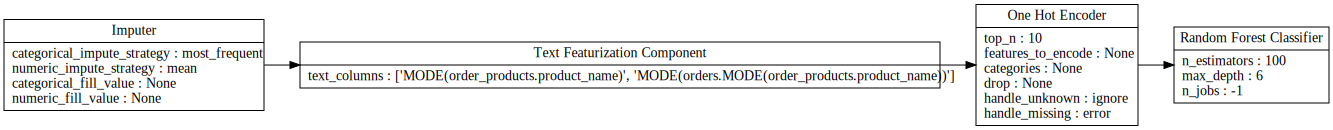

In [17]:
automl.best_pipeline.describe()
automl.best_pipeline.graph()

Score the model performance by evaluating predictions on the holdout set.

In [18]:
best_pipeline = automl.best_pipeline.fit(X_train, y_train)

score = best_pipeline.score(
    X=X_holdout,
    y=y_holdout,
    objectives=['f1'],
)

dict(score)

{'F1': 1.0}

From the pipeline, you can see which features are most important for predictions.

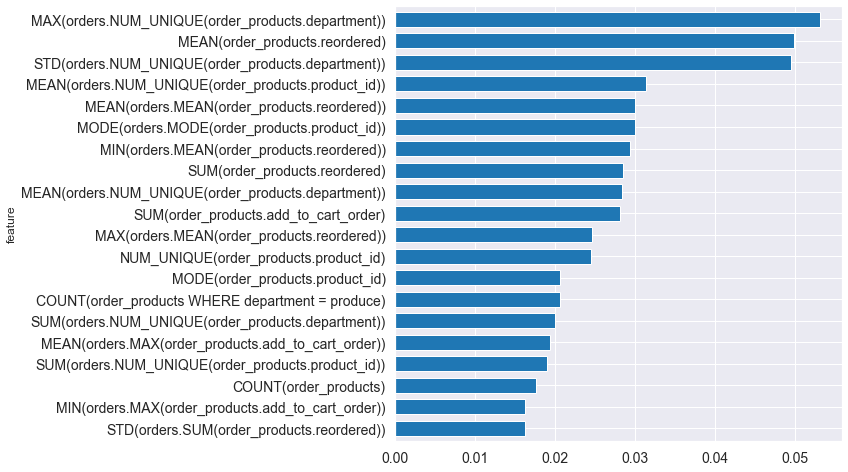

In [19]:
feature_importance = best_pipeline.feature_importance
feature_importance = feature_importance.set_index('feature')['importance']
top_k = feature_importance.abs().sort_values().tail(20).index
feature_importance[top_k].plot.barh(figsize=(8, 8), fontsize=14, width=.7);

### Making Predictions

You are ready to make predictions with your trained model. Start by calculating the same set of features by using the feature definitions. Also, use a cutoff time based on the latest information available in the dataset.

In [20]:
fm = ft.calculate_feature_matrix(
    features=fd,
    entityset=es,
    cutoff_time=ft.pd.Timestamp('2015-03-02'),
    cutoff_time_in_index=True,
    verbose=False,
)

fm.head()

,,COUNT(orders),COUNT(order_products),MAX(order_products.add_to_cart_order),MAX(order_products.reordered),MEAN(order_products.add_to_cart_order),MEAN(order_products.reordered),MIN(order_products.add_to_cart_order),MIN(order_products.reordered),MODE(order_products.department),MODE(order_products.product_id),...,SUM(orders.NUM_UNIQUE(order_products.product_id)),SUM(orders.NUM_UNIQUE(order_products.product_name)),SUM(orders.SKEW(order_products.add_to_cart_order)),SUM(orders.SKEW(order_products.reordered)),SUM(orders.STD(order_products.add_to_cart_order)),SUM(orders.STD(order_products.reordered)),COUNT(order_products WHERE department = produce),COUNT(order_products WHERE product_name = Banana),MODE(order_products.orders.user_id),NUM_UNIQUE(order_products.orders.user_id)
user_id,time,,,,,,,,,,,,,,,,,,,,,
19114,2015-03-02,2,43,25,1,11.534884,0.302326,1,0,produce,4269,...,43,43,0,-1.084861,12.698340,0.460889,19,0.0,19114,1
31606,2015-03-02,4,40,12,1,5.625000,0.950000,1,0,dairy eggs,4957,...,40,40,0,-1.922718,12.110279,0.404520,12,0.0,31606,1
37804,2015-03-02,5,43,11,1,5.000000,0.953488,1,0,produce,33120,...,43,43,0,-0.968246,13.113964,0.516398,30,0.0,37804,1
8167,2015-03-02,3,26,9,1,4.846154,0.961538,1,0,produce,8277,...,26,26,0,-2.828427,7.926715,0.353553,10,0.0,8167,1
57362,2015-03-02,3,45,23,1,9.422222,0.866667,1,0,produce,24489,...,45,45,0,-5.340821,13.414713,0.679940,10,0.0,57362,1


Predict whether customers will purchase bananas within the next 3 days.

In [21]:
values = best_pipeline.predict(fm).values

prediction = fm[[]]
prediction['bought_product (estimate)'] = values
prediction.head()

,,bought_product (estimate)
user_id,time,
19114,2015-03-02,True
31606,2015-03-02,True
37804,2015-03-02,True
8167,2015-03-02,False
57362,2015-03-02,True


### Next Steps

You have completed this tutorial. You can revisit each step to explore and fine-tune the model using different parameters until it is ready for production. For more information about how to work with the features produced by Featuretools, take a look at [the Featuretools documentation](https://docs.featuretools.com/). For more information about how to work with the models produced by EvalML, take a look at [the EvalML documentation](https://evalml.alteryx.com/).